In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors
from matplotlib import gridspec
from scipy.spatial import cKDTree
import scipy.spatial.distance
from skimage.color import rgb2hsv
from skimage.color import hsv2rgb
from skimage.color import rgb2lab
from skimage.color import lab2rgb
from skimage.util import img_as_ubyte
from skimage.util import img_as_float
import numpy as np
import cv2
from PIL import Image
import os
import itertools as it

- - - 
##  Přebarvení rastrů CO podle předem definované palety barev  
 - pomocí scipy.spatial.cKDTree algoritmu [https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.cKDTree.html] 
 - test proveden v barevném prostoru RGB, HSV a LAB(CIELAB)  
 
 **Paleta** (viz.: Obtain color-palette using clustering with k-means algorithm from **"KmeansClustering.ipynb"**):  
 ![24color paleta](rgb24_pal.png "Použitá paleta")

 - - - 
 ### Helper functions

In [2]:
def img_resize(image, n=480):
    '''Rescale image to default size of n
    
    Maintains the aspect ratio rescales the longer side to required n
    
    Args
    ---
        image (Image.fromarray): RGB image from numpy array with PIL Image.fromarray()
        n (int): required size of image, default is n
    '''
    if image.width > n or image.height > 1028:
        if image.height > image.width:
            factor = n / image.height
        else:
            factor = n / image.width
        tn_image = image.resize((int(image.width * factor), int(image.height * factor)))
        return tn_image

In [3]:
def visualize_palette(palette, scale=0):
    '''Visualizes a palette as a rectangle of increasingly "bright" colors.

    This method first converts the RGB pixels into grayscale and sorts the
    grayscale pixel intensity as a proxy of sorting the RGB pixels. Then the
    pixels are reshaped into a 2:1 rectangle and displayed. If there are more
    fewer pixels tahn the size of the rectangle, the remaining pixels are given
    a generic gray color.

    Args
    ---
        palette (numpy.ndarray): the RGB pixels of a  color palette.
        scale (int): the scale factor to apply to the image of the palette.
    '''
    palette_gray = palette @ np.array([[0.21, 0.71, 0.07]]).T
    idx = palette_gray.flatten().argsort()
    h, w = closest_rect(palette.shape[0])
    palette_sorted = palette[idx]
    padding = (h*w) - palette.shape[0]
    
    if (h*w) > palette.shape[0]:
        palette_sorted = np.vstack(
            (palette_sorted, 51*np.ones((padding, 3), dtype=np.uint8))
        )

    palette_sorted = palette_sorted.reshape(h, w, 3)
    im = Image.fromarray(palette_sorted)
    
    if scale > 0:
        return im.resize((scale*im.width, scale*im.height), Image.NEAREST)

    return im

In [4]:
def closest_rect(n):
    '''Finds the closest height and width of a 2:1 rectangle given the number
    of pixels.

    Args
    ---
        n (int): the number of pixels in an image.
    '''
    k = 0
    while 2 * k ** 2 < n:
        k += 1
    
    return k, 2*k

In [5]:
# OpenCV method to resize IMAGE-ARRAY
# we use resized array to shorten plot time
def res_img_arr(img, x=240, y=180):
    '''
    Uz se mi ani neche psat docstring
    '''
    res_img = cv2.resize(img, dsize=(x, y), interpolation=cv2.INTER_CUBIC)
    return res_img

In [6]:
def plot_samples(pics, rows=3,cols=4, offset=0, fig_x=16, fig_y=9, im_rsz=320):
    plt.figure()
    offset = offset
    rows, cols = rows, cols
    f, ax = plt.subplots(rows, cols,figsize=(fig_x,fig_y)) 
    count = 0
    for row in range(rows):
        for col in range(cols):
            pic_name = f'{pics[count+offset]}'
            img = img_resize(Image.open(os.path.join(samples, pic_name)),im_rsz)
            ax[row, col].imshow(img)
            ax[row, col].set_yticklabels([])
            ax[row, col].set_xticklabels([])
            ax[row, col].annotate(f'{pic_name} \nIndex: {count}',
                                  (0.1, 0.5), xycoords='axes fraction', va='center')
            count += 1

    plt.subplots_adjust(wspace=0, hspace=0.1)
    plt.show()

In [7]:
class multiArrayPicture:
    '''
    TODO docstring
    '''
    def __init__(self, img):
        self.img = img
        
    def img_samples(self, samp):
        self.samp = samp
        

In [8]:
# converting above RGB picture to float HSV values  ..as numpy array of course
def toHSV(img):
    img = rgb2hsv(img)
    return img

def fromHSV(img):
    img = img_as_ubyte(hsv2rgb(img))
    return img

In [9]:
def toLAB(img):
    img = rgb2lab(img)
    return img

def fromLAB(img):
    img = img_as_ubyte(lab2rgb(img))
    return img

In [10]:
def arrLookup(arr):
    print(arr.shape, arr.dtype)
    print(arr[:2,:3,:])

In [11]:
def imgAsRescaledArray(idx, folder, x=400, y=300):
    samples = os.path.join(os.getcwd(), folder)
    pics = os.listdir(samples)
    img = Image.open(os.path.join(samples, pics[idx]))
    img = np.array(img)
    img = res_img_arr(img, x, y)
    return img

 - - - 
 ### List and display sample images

In [12]:
samples = os.path.join(os.getcwd(), 'samples')
pics = os.listdir(samples)
pics

['0347-1-002.jpg',
 '0347-1-005.jpg',
 '0687-1-003.jpg',
 '0979-1-025.jpg',
 '0990-1-004.jpg',
 '0990-1-005.jpg',
 '1273-1-003.jpg',
 '1273-1-005.jpg',
 '2430-1-004.jpg',
 '3302-1-002.jpg',
 '7471-1-003.jpg',
 '8131-1-002.jpg']

<Figure size 432x288 with 0 Axes>

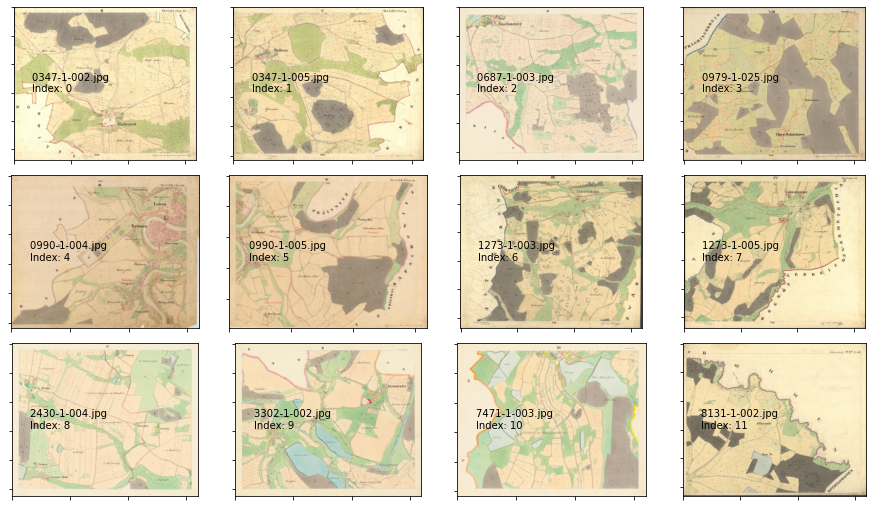

In [13]:
 plot_samples(pics)

In [27]:
# Prepare image for analysis - downsample and convert to array
img1 = imgAsRescaledArray(2, 'samples', 400, 300)

In [28]:
arrLookup(img1)

(300, 400, 3) uint8
[[[245 233 207]
  [243 231 205]
  [244 232 206]]

 [[244 232 206]
  [245 233 207]
  [244 232 206]]]


- - - 
### Konverze RGB to HSV

In [29]:
# RGB image index 1 to HSV
img1_hsv = toHSV(img1)

In [30]:
# View array composition
arrLookup(img1_hsv)

(300, 400, 3) float64
[[[0.11403509 0.15510204 0.96078431]
  [0.11403509 0.1563786  0.95294118]
  [0.11403509 0.1557377  0.95686275]]

 [[0.11403509 0.1557377  0.95686275]
  [0.11403509 0.15510204 0.96078431]
  [0.11403509 0.1557377  0.95686275]]]


- - - 
### Konverze RGB to CIELAB
    **Function name**    **Description**
    
    img_as_float    Convert to 64-bit floating point.
    img_as_ubyte    Convert to 8-bit uint.
    img_as_uint    Convert to 16-bit uint.
    img_as_int    Convert to 16-bit int.

img_as_ubyte(image)

In [31]:
# RGB image index 1 to LAB
img1_lab = toLAB(img1)

In [32]:
# View array composition
arrLookup(img1_lab)

(300, 400, 3) float64
[[[92.6615557  -0.13872439 14.10439148]
  [91.96035235 -0.13510668 14.12790589]
  [92.31109463 -0.13692446 14.11611961]]

 [[92.31109463 -0.13692446 14.11611961]
  [92.6615557  -0.13872439 14.10439148]
  [92.31109463 -0.13692446 14.11611961]]]


- - - 
### Definovani vlastni palety barev

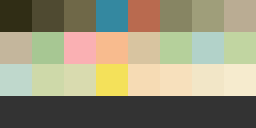

In [33]:
# testovaci k=24 color paleta vytvorena k-mean clustering
# na jednom zvolenem optimal. obrazku
rgb_24_color_palette = np.array([[167, 199, 147],
       [247, 224, 188],
       [135, 133,  99],
       [206, 217, 169],
       [246, 235, 206],
       [ 48,  45,  21],
       [178, 210, 201],
       [196, 182, 156],
       [111, 104,  72],
       [248, 187, 142],
       [186, 172, 147],
       [193, 213, 161],
       [250, 176, 179],
       [ 52, 136, 160],
       [159, 158, 122],
       [216, 196, 160],
       [217, 219, 175],
       [244, 225,  90],
       [ 79,  74,  49],
       [242, 230, 199],
       [246, 219, 180],
       [185, 106,  79],
       [191, 216, 204],
       [181, 208, 155]]).astype(np.uint8)
visualize_palette(rgb_24_color_palette, scale=32)

In [34]:
def toFloat(img):
    img = img_as_float(img)
    return img

def fromFloat(img):
    img = img_as_ubyte(img)
    return img

In [35]:
# normovana RGB paleta [0 az 1] jako list pro 3D plot barevnych prostoru
# normRGBpalette = img_as_float(rgb_24_color_palette).tolist()


- - - 
## OpenCV testing 3D plotinng of colourspace

In [36]:
# PLOTTING 3D COLOURSPACE OF PALETTE IN RGB


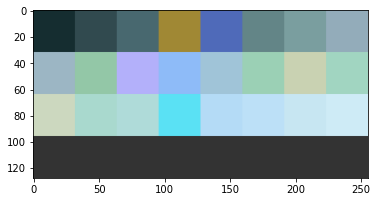

In [37]:
pal = cv2.imread('rgb24_pal.png')
plt.imshow(pal)
plt.show()


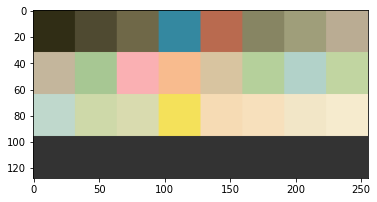

In [38]:
pal = cv2.cvtColor(pal, cv2.COLOR_BGR2RGB)
plt.imshow(pal)
plt.show()

In [41]:
# konverze RGB palety do HSV
hsv_24_color_palette = rgb2hsv(rgb_24_color_palette).astype(np.float32)

In [ ]:
lab_24_color_palette = rgb2hsv(rgb_24_color_palette).astype(np.float32)

- - - 
## 3D plot function

In [42]:
def y_view(nrow, ncol, sta=-60, stp=210):
    y_vw_list = []
    for i in range(sta, stp, int(270/(nrow*ncol))):
        y_vw_list.append(i)
    return y_vw_list

In [50]:
def plotQuat3D(img, pal, img_rgb, pal_rgb, nrow=2, ncol =2, xview=30):
    # prepare rotations
    yview=y_view(nrow, ncol, sta=-60, stp=210)
    
    # prepare image
    x, y, z = cv2.split(img)
    # prepare color palette
    pal_x = pal[:,0]
    pal_y = pal[:,1]
    pal_z = pal[:,2]
    
    img_colors = toFloat(img_rgb.reshape(-1, img_rgb.shape[-1])).tolist()
    pal_colors = toFloat(pal_rgb.reshape(-1, pal_rgb.shape[-1])).tolist()
    
    fig = plt.figure(figsize=(18,14))
    
    count = 0
    for i in range(nrow):
        for j in range(ncol):
            ax = plt.subplot2grid((nrow,ncol), (i, j), projection="3d")
            ax.scatter(x.flatten(), y.flatten(), z.flatten(), facecolors=img_colors, marker=".", s=1, zorder=-1)
            ax.scatter(pal_x, pal_y, pal_z, facecolors=pal_colors, marker=".", edgecolors= "blue", s=450, zorder=2)
#             ax.set_yticklabels([])
#             ax.set_xticklabels([])
#             ax.set_zticklabels([])
            ax.set_xlabel("X")
            ax.set_ylabel("Y")
            ax.set_zlabel("Z")
            ax.view_init(xview,yview[count])
            count += 1

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

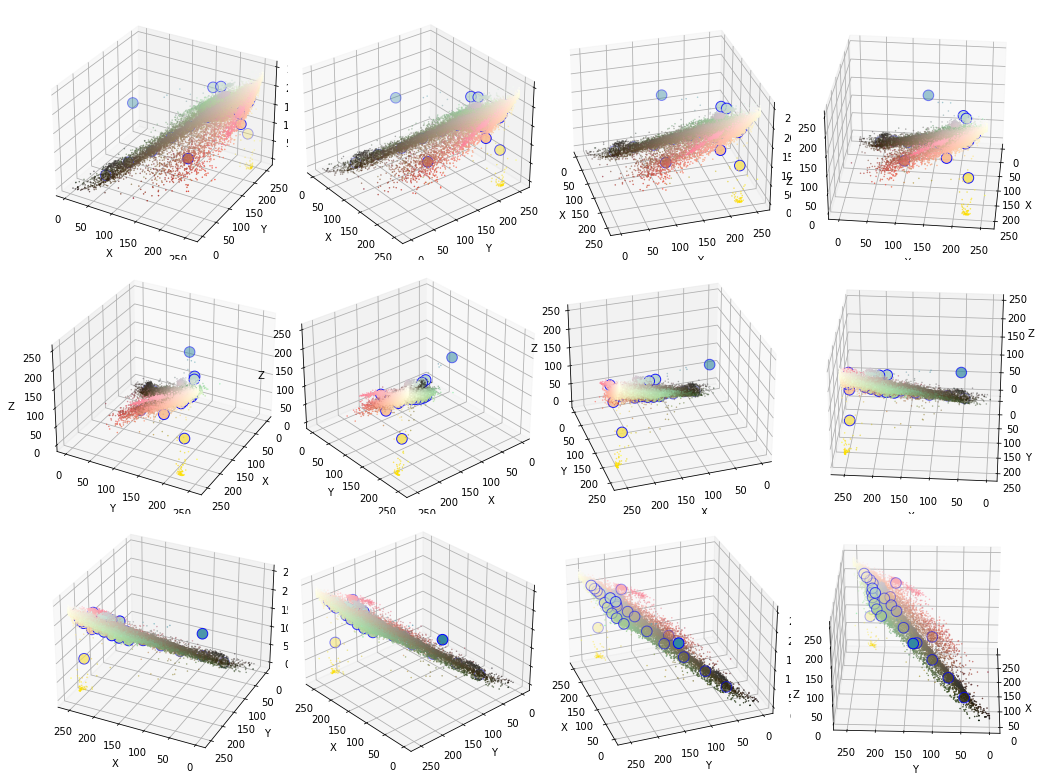

In [51]:
plotQuat3D(img1, rgb_24_color_palette, img1, rgb_24_color_palette, 3, 4)

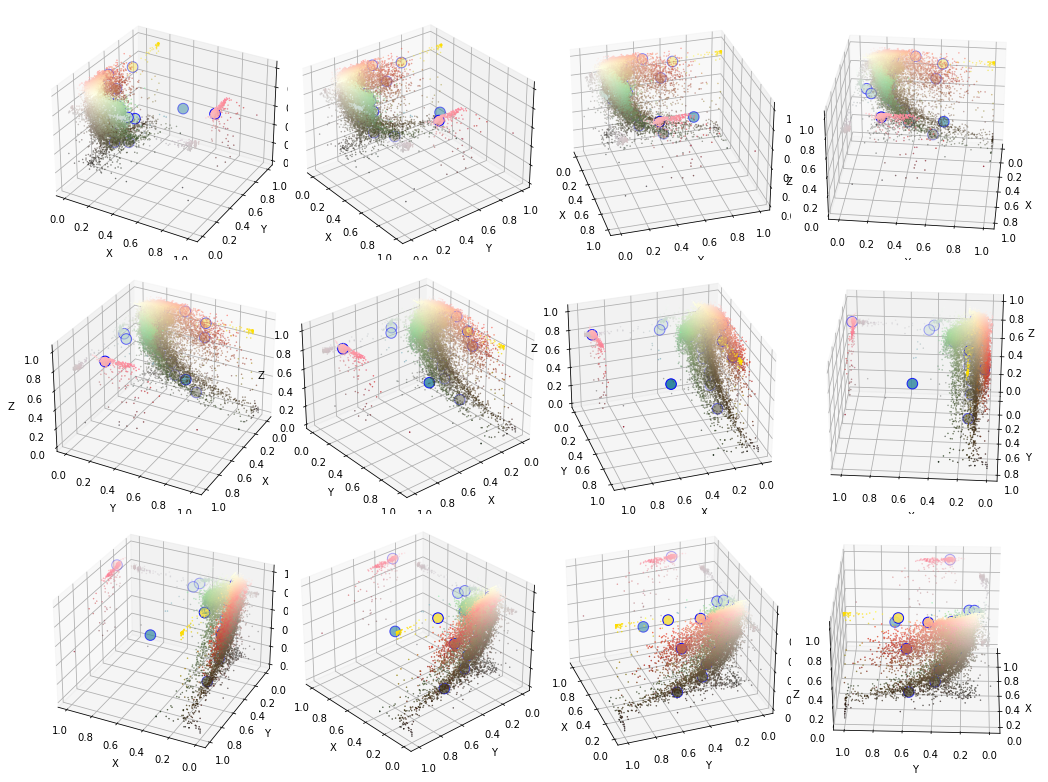

In [46]:
plotQuat3D(toHSV(img1), toHSV(rgb_24_color_palette), img1, rgb_24_color_palette, 3, 4)

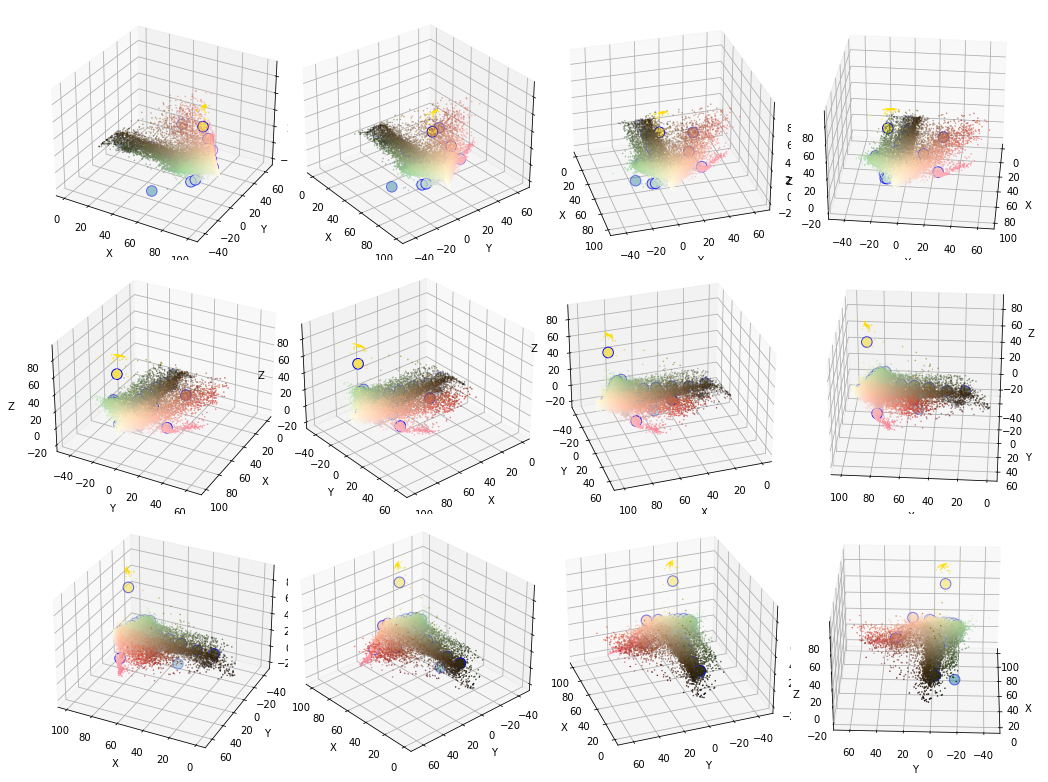

In [47]:
plotQuat3D(toLAB(img1), toLAB(rgb_24_color_palette), img1, rgb_24_color_palette, 3, 4)

- - - 
### Reklasifikace pixelu obrazku metodou "nearest-neighbor lookup"

In [52]:
def ckDTreeReclass(img, pal):
    recl_img = pal = pal[cKDTree(pal).query(img,k=1)[1]]
    return recl_img

In [53]:
%%time
# RGB klasifikace podle palety
img1_recl_rgb = ckDTreeReclass(img1, rgb_24_color_palette)

Wall time: 88 ms


In [54]:
%%time
# HSV klasifikace podle palety a prevod na RGB integer
img1_recl_hsv = ckDTreeReclass(toHSV(img1), toHSV(rgb_24_color_palette))
img1_recl_hsv = fromHSV(img1_recl_hsv)

Wall time: 132 ms


In [55]:
%%time
# LAB klasifikace podle palety
img1_recl_lab = ckDTreeReclass(toLAB(img1), toLAB(rgb_24_color_palette))
img1_recl_lab = fromLAB(img1_recl_lab)

Wall time: 179 ms


In [56]:
recl_imgs = [img1, img1_recl_rgb, img1_recl_hsv, img1_recl_lab]

for i in recl_imgs:
#     print(f'Reclassified array of: {i}')
    print(i.shape, i.dtype)
    print(i[:9,4,:])
    print('\n')

(300, 400, 3) uint8
[[240 228 202]
 [243 231 205]
 [243 231 205]
 [243 231 205]
 [246 235 207]
 [242 230 204]
 [241 229 203]
 [248 236 210]
 [244 232 206]]


(300, 400, 3) uint8
[[242 230 199]
 [246 235 206]
 [246 235 206]
 [246 235 206]
 [246 235 206]
 [242 230 199]
 [242 230 199]
 [246 235 206]
 [246 235 206]]


(300, 400, 3) uint8
[[242 230 199]
 [246 235 206]
 [246 235 206]
 [246 235 206]
 [246 235 206]
 [246 235 206]
 [242 230 199]
 [246 235 206]
 [246 235 206]]


(300, 400, 3) uint8
[[242 230 199]
 [246 235 206]
 [246 235 206]
 [246 235 206]
 [246 235 206]
 [246 235 206]
 [246 235 206]
 [246 235 206]
 [246 235 206]]




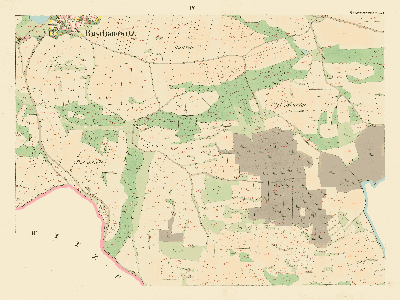

In [57]:
# DISPLAYING OUR RECLASIFF IMAGES
# RGB
display(Image.fromarray(img1_recl_rgb))

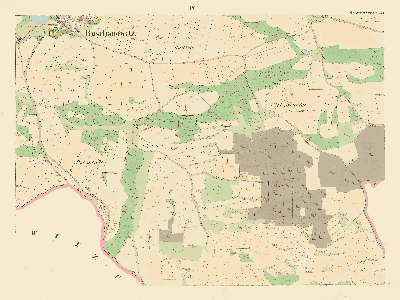

In [58]:
# HSV
display(Image.fromarray(img1_recl_hsv))

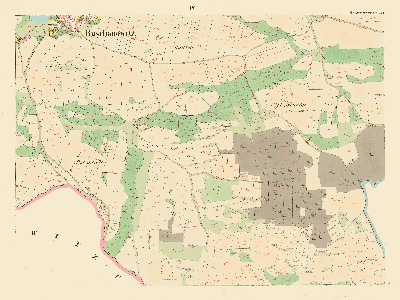

In [59]:
# LAB
display(Image.fromarray(img1_recl_lab))

In [60]:
recl_names = ['img1','img1_recl_rgb', 'img1_recl_hsv', 'img1_recl_lab']
counter = 0
for img in recl_imgs:
    Image.fromarray(img).save(f'{recl_names[counter]}_{pics[1]}')
    print(f'{recl_names[counter]}_{pics[1]}')
    counter += 1

img1_0347-1-005.jpg
img1_recl_rgb_0347-1-005.jpg
img1_recl_hsv_0347-1-005.jpg
img1_recl_lab_0347-1-005.jpg


In [61]:
res = [x for x in os.listdir(os.getcwd()) if x.endswith('5.jpg')]
res

['img1_0347-1-005.jpg',
 'img1_recl_hsv_0347-1-005.jpg',
 'img1_recl_lab_0347-1-005.jpg',
 'img1_recl_rgb_0347-1-005.jpg']

<Figure size 432x288 with 0 Axes>

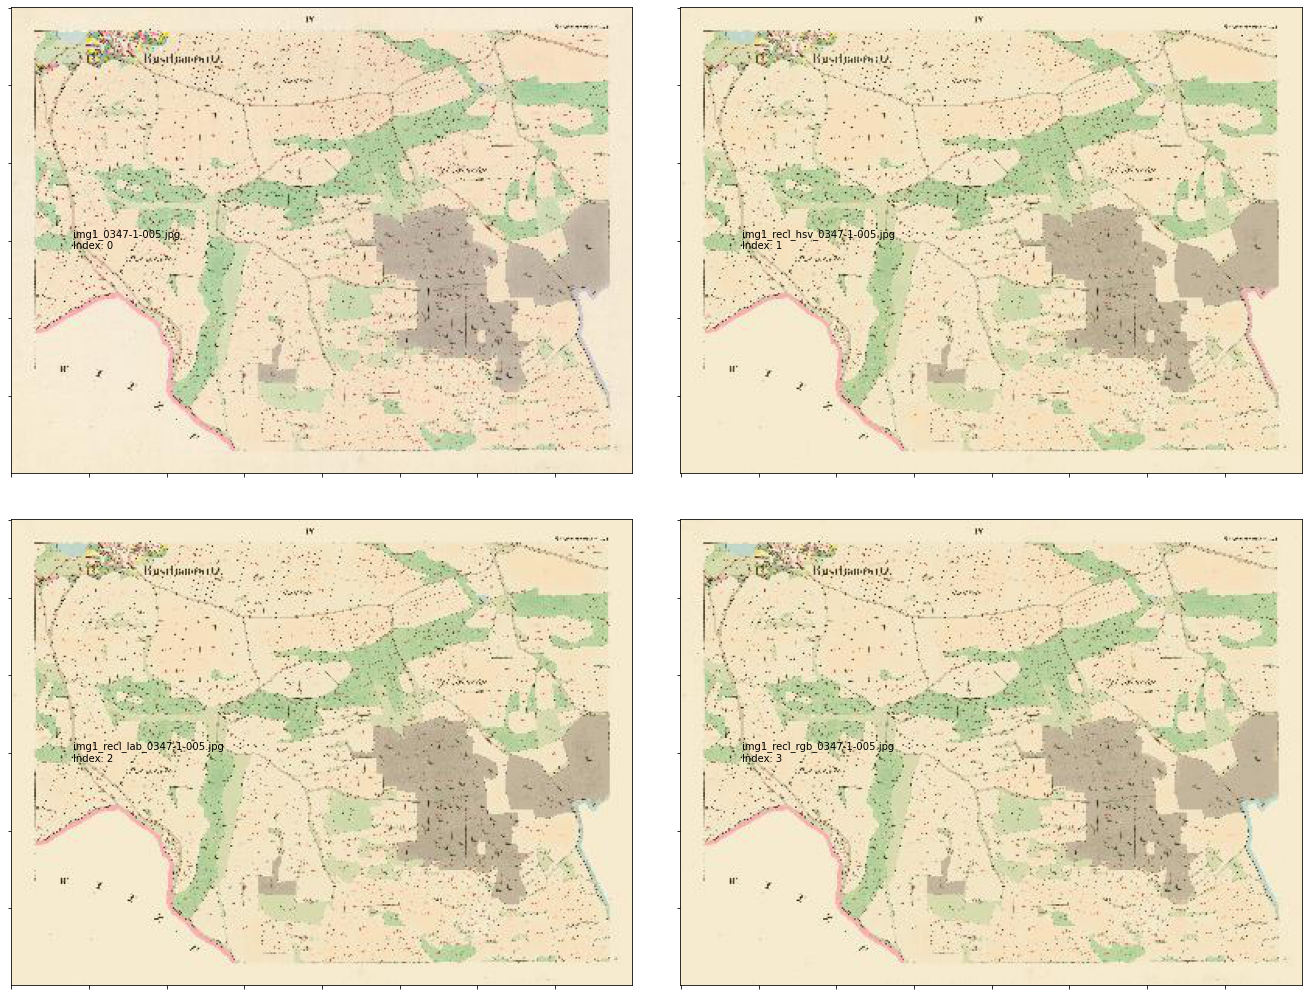

Wall time: 833 ms


In [62]:
%%time
plt.figure()
#subplot(r,c) provide the no. of rows and columns

offset = 0

rows, cols = 2, 2

f, ax = plt.subplots(rows, cols,figsize=(24,18)) 

count = 0
for row in range(rows):
    for col in range(cols):
        pic_name = f'{res[count+offset]}'
        img = Image.open(pic_name)
        ax[row, col].imshow(img)
        ax[row, col].set_yticklabels([])
        ax[row, col].set_xticklabels([])
        ax[row, col].annotate(f'{pic_name} \nIndex: {count}',
                              (0.1, 0.5), xycoords='axes fraction', va='center')
        count += 1

plt.subplots_adjust(wspace=0, hspace=0.1)
plt.show()

-  - -
## Computing spatial distance

In [ ]:
palette  = np.array([[0, 0, 0], 
[0, 0, 255], 
[255, 0, 0], 
[150, 30, 150], 
[255, 65, 255], 
[150, 80, 0], 
[170, 120, 65], 
[125, 125, 125], 
[255, 255, 0], 
[0, 255, 255], 
[255, 150, 0], 
[255, 225, 120], 
[255, 125, 125], 
[200, 100, 100], 
[0, 255, 0], 
[0, 150, 80], 
[215, 175, 125], 
[220, 180, 210], 
[125, 125, 255]
])

valueRange = np.arange(0,256)
allColors = np.array(list(it.product(valueRange,valueRange,valueRange)))
mapping = scipy.spatial.distance.cdist(allColors, palette, metric='euclidean').argmin(1)


In [97]:
img1.shape[0]

300

In [99]:
# plotQuat3D(toHSV(img1), toHSV(rgb_24_color_palette), img1, rgb_24_color_palette, 3, 4)
def reshape3Dto2D(img):
    img = img.reshape(-1, img.shape[-1])
    return img

def reshape2Dto3D(img, orig_img):
    img = img.reshape(orig_img.shape[0], orig_img.shape[1], 3).astype(np.uint8)
    return img

In [82]:
eucl_mapping = scipy.spatial.distance.cdist(reshape3Dto2D(img1), rgb_24_color_palette, metric='euclidean').argmin(1)

In [85]:
img1_remap_eucl = rgb_24_color_palette[eucl_mapping]
img1_remap_eucl.shape

(120000, 3)

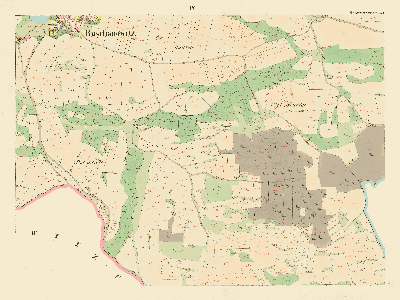

In [100]:
display(Image.fromarray(reshape2Dto3D(img1_remap_eucl, img1)))

In [101]:
maha_mapping = scipy.spatial.distance.cdist(reshape3Dto2D(img1), rgb_24_color_palette, metric='mahalanobis').argmin(1)

In [102]:
img1_remap_maha = rgb_24_color_palette[maha_mapping]

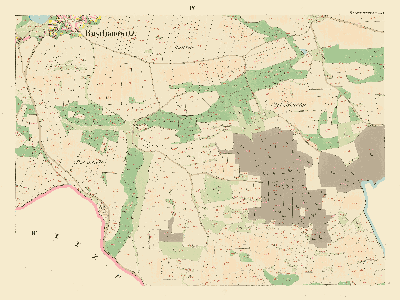

In [103]:
display(Image.fromarray(reshape2Dto3D(img1_remap_maha, img1)))

In [107]:
def pic2pal_mapping(img, pal, typ_dist):
    '''
    typ_dist = ['euclidean', 'mahalanobis']
    '''
    img = scipy.spatial.distance.cdist(reshape3Dto2D(img), pal, metric=typ_dist).argmin(1)
    return img

In [111]:
def img2fullArr(idx):
    img = Image.open(os.path.join(samples, pics[idx]))
    img = np.array(img)
    return img

In [113]:
img_full = img2fullArr(2)

In [114]:
img_full_eucl_map = pic2pal_mapping(img_full, rgb_24_color_palette, 'euclidean')

In [116]:
%%time
img_full_maha_map = pic2pal_mapping(img_full, rgb_24_color_palette, 'mahalanobis')

Wall time: 25.4 s


In [117]:
def recolorByMapp(pal, mapp, orig_img):
    img = pal[mapp]
    img = reshape2Dto3D(img, orig_img)
    return img

In [119]:
%%time
EucRecolor = recolorByMapp(rgb_24_color_palette, img_full_eucl_map, img_full)

Wall time: 663 ms


In [120]:
%%time
MahaRecolor = recolorByMapp(rgb_24_color_palette, img_full_maha_map, img_full)

Wall time: 694 ms


In [121]:
Image.fromarray(EucRecolor).save(f'EucRecolor_inRGBspace_{pics[2]}')

In [122]:
%%time
Image.fromarray(MahaRecolor).save(f'MahaRecolor_inRGBspace_{pics[2]}')

Wall time: 936 ms


In [131]:
%%time
HSVimg_full_eucl_map = pic2pal_mapping(toHSV(img_full), toHSV(rgb_24_color_palette), 'euclidean')

Wall time: 21.5 s


In [130]:
%%time
HSVimg_full_maha_map = pic2pal_mapping(toHSV(img_full), toHSV(rgb_24_color_palette), 'mahalanobis')

Wall time: 36.7 s


In [132]:
HSV_EucRecolor = recolorByMapp(rgb_24_color_palette, HSVimg_full_eucl_map, img_full)

In [133]:
HSV_MahaRecolor = recolorByMapp(rgb_24_color_palette, HSVimg_full_maha_map, img_full)

In [134]:
Image.fromarray(HSV_EucRecolor).save(f'EucRecolor_inHSVspace_{pics[2]}')

In [135]:
Image.fromarray(HSV_MahaRecolor).save(f'MahaRecolor_inHSVspace_{pics[2]}')

In [136]:
%%time
LABimg_full_eucl_map = pic2pal_mapping(toLAB(img_full), toLAB(rgb_24_color_palette), 'euclidean')

Wall time: 31.6 s


In [137]:
%%time
LABimg_full_maha_map = pic2pal_mapping(toLAB(img_full), toLAB(rgb_24_color_palette), 'mahalanobis')

Wall time: 46.1 s


In [138]:
%%time
LAB_EucRecolor = recolorByMapp(rgb_24_color_palette, LABimg_full_eucl_map, img_full)

Wall time: 709 ms


In [139]:
%%time
LAB_MahaRecolor = recolorByMapp(rgb_24_color_palette, LABimg_full_maha_map, img_full)

Wall time: 708 ms


In [140]:
Image.fromarray(LAB_EucRecolor).save(f'EucRecolor_inLABspace_{pics[2]}')

In [141]:
Image.fromarray(LAB_MahaRecolor).save(f'MahaRecolor_inLABspace_{pics[2]}')